# Train collaborative-filter recommender

In [3]:
%pylab inline

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import sqlite3
import pandas as pd

import surprise
from surprise.model_selection import cross_validate

Populating the interactive namespace from numpy and matplotlib


# Load data

In [44]:
filename = '../data/mountain_project_gunks.sqlite'
conn = sqlite3.connect(filename)

# Ratings of each route
df_ratings = pd.read_sql('SELECT * FROM ratings', conn)

In [46]:
display(df_ratings.head(5))

,uid,iid,rating
0,0,0,2
1,1,0,2
2,2,0,2
3,3,0,1
4,4,0,1


# Construct training set in surprise's data format

In [25]:
reader = surprise.Reader()
data = surprise.Dataset.load_from_df(df_ratings[['uid', 'iid', 'rating']], reader)
trainset = data.build_full_trainset()

In [26]:
print trainset.n_users, trainset.n_items, trainset.n_ratings

2432 470 31431


# Root mean squared error if you just predict the mean rating.

In [47]:
rs = df_ratings['rating'].values

n = len(rs)
rmean = rs.mean()
rmse = np.sqrt(np.sum((rs-rmean)**2)/n)

print(rmean, rmse)

(2.95463077853075, 0.8662467838375435)


# Establish baseline with standard algorithms (random, means, SVD)

In [27]:
algo = surprise.NormalPredictor()

# Fit with entire training set
algo.fit(trainset)
predictions_train = algo.test(trainset.build_testset())
rmse_train = surprise.accuracy.rmse(predictions_train)

# Fit for each of k folds
cv = cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)
rmse_cv = cv['test_rmse'].mean()

print rmse_train, rmse_cv

RMSE: 1.2103
Evaluating RMSE, MAE of algorithm NormalPredictor on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
MAE (testset)     0.9836  0.9759  0.9799  0.9798  0.9849  0.9808  0.0032  
RMSE (testset)    1.2251  1.2103  1.2046  1.2205  1.2238  1.2169  0.0080  
Fit time          0.05    0.05    0.05    0.06    0.05    0.05    0.00    
Test time         0.05    0.05    0.05    0.05    0.05    0.05    0.00    
1.2103455670747938 1.2168772018293599


In [28]:
algo = surprise.BaselineOnly()

# Fit with entire data set
algo.fit(trainset)
predictions_train = algo.test(trainset.build_testset())
rmse_train = surprise.accuracy.rmse(predictions_train)

# Fit for each of k folds
cv = cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)
rmse_cv = cv['test_rmse'].mean()

print rmse_train, rmse_cv

Estimating biases using als...
RMSE: 0.6039
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Evaluating RMSE, MAE of algorithm BaselineOnly on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
MAE (testset)     0.5010  0.4961  0.4966  0.4938  0.4935  0.4962  0.0027  
RMSE (testset)    0.6359  0.6349  0.6318  0.6273  0.6271  0.6314  0.0037  
Fit time          0.04    0.05    0.05    0.05    0.06    0.05    0.00    
Test time         0.05    0.05    0.06    0.05    0.13    0.07    0.03    
0.6039182292485047 0.6314052132529651


In [29]:
algo = surprise.SVD()

# Fit with entire data set
algo.fit(trainset)
predictions_train = algo.test(trainset.build_testset())
rmse_train = surprise.accuracy.rmse(predictions_train)

# Fit for each of k folds
cv = cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)
rmse_cv = cv['test_rmse'].mean()

print rmse_train, rmse_cv

RMSE: 0.5094
Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
MAE (testset)     0.4873  0.5024  0.4919  0.4952  0.4900  0.4934  0.0052  
RMSE (testset)    0.6237  0.6449  0.6263  0.6329  0.6303  0.6316  0.0074  
Fit time          1.49    1.40    1.40    1.38    1.36    1.41    0.05    
Test time         0.06    0.12    0.05    0.05    0.05    0.07    0.03    
0.5093718060571587 0.6316296940211322


## Tune parameters for user-based KNN

In [30]:
ks = [1, 2, 5, 10, 20, 50, 100, 200, 500, 1000]

errors = []
for k in ks:
    sim_options = {'name': 'msd', 'user_based': True}
    #sim_options = {'name': 'pearson_baseline', 'user_based': True}
    #sim_options = {'name': 'pearson', 'user_based': True}
    #sim_options = {'name': 'cosine', 'user_based': True}
    
    #algo = surprise.KNNBasic(k=k, min_k=1, sim_options=sim_options)
    algo = surprise.KNNBaseline(k=k, min_k=1, sim_options=sim_options)
    
    # Fit with entire data set
    algo.fit(trainset)
    predictions_train = algo.test(trainset.build_testset())
    
    # Compute RMSE
    rmse_train = surprise.accuracy.rmse(predictions_train)
    
    # Fit for each of k folds
    cv = cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)
    rmse_cv = cv['test_rmse'].mean()
    
    e = [k, rmse_train, rmse_cv]
    print e
    errors.append(e)

errors = np.array(errors)

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.1669
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNBaseline on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
MAE (testset)     0.6281  0.6293  0.6212  0.6237  0.6132  0.6231  0.0057  
RMSE (testset)    0.8484  0.8340  0.8263  0.8368  0.8242  0.8339  0.0086  
Fit time          0.32    0.29    0.31    0.28    0.30    0.30    0.02    
T

Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNBaseline on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
MAE (testset)     0.4815  0.4845  0.4743  0.4836  0.4834  0.4815  0.0037  
RMSE (testset)    0.6231  0.6213  0.6082  0.6236  0.6215  0.6196  0.0058  
Fit time          0.31    0.30    0.31    0.31    0.32    0.31    0.00    
Test time         3.44    3.46    3.36    3.42    3.43    3.42    0.03    
[200, 0.5075791232547051, 0.6195550221929069]
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.5398
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd simil

In [32]:
imin = errors[:, 2].argmin()

print errors[imin]
print algo.sim_options

[500.           0.539779     0.61955066]
{'name': 'msd', 'user_based': True}


Text(0,0.5,'RMSE')

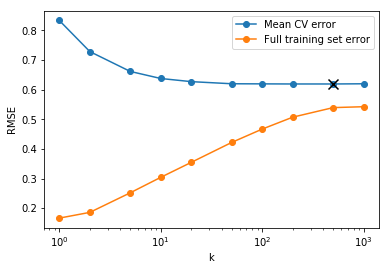

In [33]:
fig, ax = plt.subplots()
ax.plot(errors[:, 0], errors[:, 2], marker='o', label='Mean CV error')
ax.plot(errors[:, 0], errors[:, 1], marker='o', label='Full training set error')
ax.scatter(errors[imin, 0], errors[imin, 2], marker='x', c='k', s=100, zorder=5)
ax.legend()
ax.set_xscale('log')
ax.set_xlabel('k')
ax.set_ylabel('RMSE')

# Fit the final model with the best hyperparameters

In [34]:
k = 500
min_k = 1
sim_options = {'name': 'msd', 'user_based': True}
algo = surprise.KNNBaseline(k=k, min_k=1, sim_options=sim_options)
    
algo.fit(trainset)

# convert the training set into a testset format for making predictions
predictions_train = algo.test(trainset.build_testset())

# Compute RMSE
rmse_train = surprise.accuracy.rmse(predictions_train)
print rmse_train

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.5398
0.5397790000928258


## Save model

In [36]:
# Dump algorithm.
filename ='../data/model_knn_user_based'
surprise.dump.dump(filename, algo=algo)

In [37]:
# Check that reloaded algorithm produces same output
_, loaded_algo = surprise.dump.load(filename)

uid = 0
iid = 0
print algo.predict(uid, iid).est, loaded_algo.predict(uid, iid).est

1.6388636861275163 1.6388636861275163


# Tune parameters for item-based KNN

In [38]:
ks = [1, 2, 5, 10, 20, 50, 100, 200, 500, 1000]

errors = []
for k in ks:
    # "'user_based': False" means item_based
    sim_options = {'name': 'msd', 'user_based': False}
    #sim_options = {'name': 'pearson_baseline', 'user_based': False}
    #sim_options = {'name': 'pearson', 'user_based': False}
    #sim_options = {'name': 'cosine', 'user_based': False}
    
    #algo = surprise.KNNBasic(k=k, min_k=1, sim_options=sim_options)
    algo = surprise.KNNBaseline(k=k, min_k=1, sim_options=sim_options)
    
    # Fit with entire data set
    algo.fit(trainset)
    predictions_train = algo.test(trainset.build_testset())
    
    # Compute RMSE
    rmse_train = surprise.accuracy.rmse(predictions_train)
    
    # Fit for each of k folds
    cv = cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)
    rmse_cv = cv['test_rmse'].mean()
    
    e = [k, rmse_train, rmse_cv]
    print e
    errors.append(e)

errors = np.array(errors)

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.1201
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNBaseline on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
MAE (testset)     0.6217  0.6056  0.6227  0.6211  0.6101  0.6162  0.0070  
RMSE (testset)    0.8412  0.8220  0.8399  0.8312  0.8212  0.8311  0.0085  
Fit time          0.07    0.07    0.07    0.07    0.07    0.07    0.00    
T

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNBaseline on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
MAE (testset)     0.4920  0.4979  0.4975  0.4891  0.4936  0.4940  0.0033  
RMSE (testset)    0.6319  0.6418  0.6360  0.6331  0.6308  0.6347  0.0039  
Fit time          0.07    0.09    0.08    0.07    0.08    0.08    0.01    
Test time         1.04    1.07    0.99    1.07    1.07    1.05    0.03    
[200, 0.5331853758793681, 0.6347461284907785]
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.5343
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing sim

In [39]:
imin = errors[:, 2].argmin()

print errors[imin]
print algo.sim_options

[50.          0.51293566  0.63138257]
{'name': 'msd', 'user_based': False}


Text(0,0.5,'RMSE')

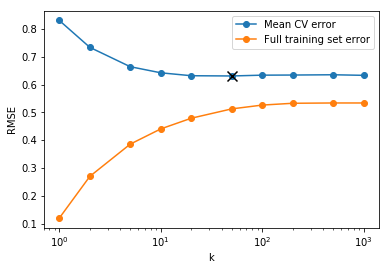

In [40]:
fig, ax = plt.subplots()
ax.plot(errors[:, 0], errors[:, 2], marker='o', label='Mean CV error')
ax.plot(errors[:, 0], errors[:, 1], marker='o', label='Full training set error')
ax.scatter(errors[imin, 0], errors[imin, 2], marker='x', c='k', s=100, zorder=5)
ax.legend()
ax.set_xscale('log')
ax.set_xlabel('k')
ax.set_ylabel('RMSE')

## Train final model

In [41]:
k = 50
min_k = 1
sim_options = {'name': 'msd', 'user_based': False}
algo = surprise.KNNBaseline(k=k, min_k=1, sim_options=sim_options)
    
algo.fit(trainset)

# convert the training set into a testset format for making predictions
predictions_train = algo.test(trainset.build_testset())

# Compute RMSE
rmse_train = surprise.accuracy.rmse(predictions_train)
print rmse_train

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.5129
0.5129356589849575


## Save model

In [42]:
# Dump algorithm.
filename ='../data/model_knn_item_based'
surprise.dump.dump(filename, algo=algo)

In [43]:
# Check that reloaded algorithm produces same output
_, loaded_algo = surprise.dump.load(filename)

uid = 0
iid = 0
print algo.predict(uid, iid).est, loaded_algo.predict(uid, iid).est

2.028957400871496 2.028957400871496
